In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import pickle
import torch
import torch.nn.functional as F

In [2]:
with open("pkl files/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

In [3]:
# Importing models
from vqmodel import *

In [4]:
# Dataframe to tensor transition
images = []

for df in chunks:
    # df['ch'] is a Series of 80 columns; each item is a list of 200 values
    # Create a (200, 80) NumPy array (transpose is needed)
    matrix = np.stack(df['PWR_ch1'].to_list(), axis=1)  # shape: (200, 80)
    images.append(matrix)

# Convert the whole thing to numpy because making tensors from a list of arrays
# is extremely slow
images_array = np.array(images)


In [5]:
# Convert to torch tensor and add batch + channel dimensions
data_tensor = torch.tensor(images_array, dtype=torch.float32)  # (B, 200, 80)
data_tensor = data_tensor.unsqueeze(1)  # (B, 1, 200, 80)

In [6]:
from torch.utils.data import DataLoader

dataset = ChunkImageDataset(chunks)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE(in_channels=1)

for batch in loader:
    print(batch.shape)  # (8, 1, 200, 80)
    outputs = model(batch)
    break  # for test

torch.Size([8, 1, 200, 80])


In [7]:
from sklearn.model_selection import train_test_split

# 1. First split: 80% train, 20% temp
train_chunks, temp_chunks = train_test_split(
    chunks, test_size=0.2, random_state=42
)

In [8]:
# 2. Split temp into 10% val, 10% test
val_chunks, test_chunks = train_test_split(
    temp_chunks, test_size=0.5, random_state=42
)

In [9]:

# Check counts
print(f"Train: {len(train_chunks)}")
print(f"Validation: {len(val_chunks)}")
print(f"Test: {len(test_chunks)}")

Train: 2478
Validation: 310
Test: 310


In [10]:
from torch.utils.data import DataLoader

# Wrap into datasets
train_dataset = ChunkImageDataset(train_chunks)
val_dataset = ChunkImageDataset(val_chunks)
test_dataset = ChunkImageDataset(test_chunks)

In [11]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Model Training

In [12]:
def train_vqvae(model, train_loader, val_loader, optimizer, device="cuda", epochs=500):
    model.to(device)

    # Initialize plot variables
    train_losses, val_losses = [], []
    recon_losses, vq_losses = [], []
    cb_losses, cm_losses = [], []
    code_usages, zq_stds = [], []
    perplexities = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, recon_total, cb_total, cm_total, vq_total = 0, 0, 0, 0, 0
        code_indices_set = set()
        zq_std_list = []
        epoch_indices = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            out["total_loss"].backward()
            optimizer.step()

            total_loss += out["total_loss"].item() * batch.size(0)
            recon_total += out["recon_loss"].item() * batch.size(0)
            cb_total += out["codebook_loss"].item() * batch.size(0)
            cm_total += out["commitment_loss"].item() * batch.size(0)
            vq_total += out["vq_loss"].item() * batch.size(0)
            code_indices_set.update(out["indices"].detach().cpu().numpy().tolist())

            epoch_indices.append(out["indices"].detach().cpu().numpy())
            zq_std_list.append(out["z_q"].std().item())

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_loss += F.mse_loss(out["recon_x"], batch).item() * batch.size(0)

        train_losses.append(total_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))
        recon_losses.append(recon_total / len(train_loader.dataset))
        cb_losses.append(cb_total / len(train_loader.dataset))
        cm_losses.append(cm_total / len(train_loader.dataset))
        vq_losses.append(vq_total / len(train_loader.dataset))
        code_usages.append(len(code_indices_set))
        zq_stds.append(np.mean(zq_std_list))

        # At the end of each epoch:
        all_indices = np.concatenate(epoch_indices)  # where epoch_indices is a list of all batch indices
        perplexity = compute_perplexity(all_indices, model.quantizer.num_embeddings)
        perplexities.append(perplexity)

        print(f"[Epoch {epoch}] Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Codes Used: {code_usages[-1]} | "
              f"Perplexity: {perplexity:.2f}")
        print(f"z_q mean: {out['z_q'].mean().item():.6f} | std: {zq_stds[-1]:.6f}")

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 4, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title("Total Loss")
    plt.legend()

    plt.subplot(2, 4, 2)
    plt.plot(epochs_range, recon_losses, label='Reconstruction Loss')
    plt.title("Reconstruction Loss")
    plt.legend()

    plt.subplot(2, 4, 3)
    plt.plot(epochs_range, cb_losses, label='Codebook Loss')
    plt.title("Codebook Loss")
    plt.legend()

    plt.subplot(2, 4, 4)
    plt.plot(epochs_range, cm_losses, label='Commitment Loss')
    plt.title("Commitment Loss")
    plt.legend()

    plt.subplot(2, 4, 5)
    plt.plot(epochs_range, vq_losses, label='VQ Loss')
    plt.title("VQ Loss")
    plt.legend()

    plt.subplot(2, 4, 6)
    plt.plot(epochs_range, code_usages, label='Unique Codes Used')
    plt.title("Codebook Usage")
    plt.legend()

    plt.subplot(2, 4, 7)
    plt.plot(perplexities, label="Codebook Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Codebook Perplexity Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()


[Epoch 1] Train Loss: 1.4240 | Val Loss: 0.7579 | Codes Used: 102 | Perplexity: 2.44
z_q mean: -0.037832 | std: 0.509864
[Epoch 2] Train Loss: 1.5798 | Val Loss: 0.7033 | Codes Used: 73 | Perplexity: 2.84
z_q mean: -0.033548 | std: 0.520771
[Epoch 3] Train Loss: 1.4415 | Val Loss: 0.6774 | Codes Used: 68 | Perplexity: 3.78
z_q mean: -0.025129 | std: 0.525406
[Epoch 4] Train Loss: 1.5077 | Val Loss: 0.6598 | Codes Used: 56 | Perplexity: 5.08
z_q mean: -0.018357 | std: 0.530266
[Epoch 5] Train Loss: 1.5934 | Val Loss: 0.6450 | Codes Used: 75 | Perplexity: 6.33
z_q mean: -0.022452 | std: 0.536165
[Epoch 6] Train Loss: 1.6755 | Val Loss: 0.6303 | Codes Used: 110 | Perplexity: 7.60
z_q mean: -0.021130 | std: 0.545980
[Epoch 7] Train Loss: 1.7536 | Val Loss: 0.6173 | Codes Used: 154 | Perplexity: 9.00
z_q mean: -0.018988 | std: 0.559860
[Epoch 8] Train Loss: 1.8526 | Val Loss: 0.6035 | Codes Used: 175 | Perplexity: 10.52
z_q mean: -0.017147 | std: 0.573617
[Epoch 9] Train Loss: 1.9764 | Val 

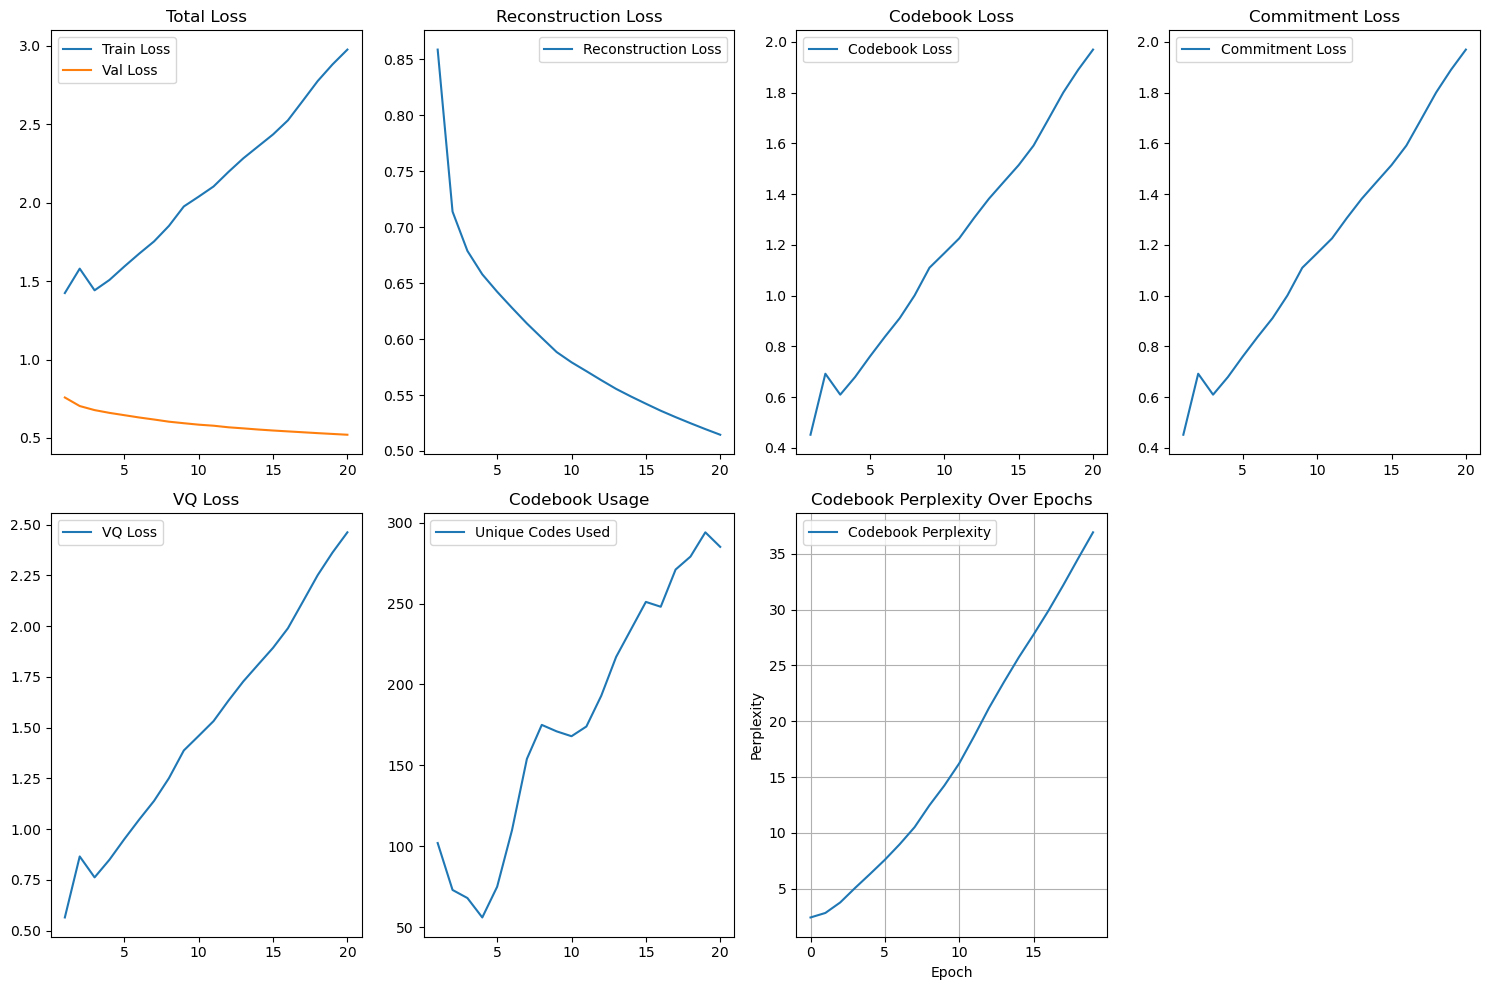

<Figure size 640x480 with 0 Axes>

In [13]:
model = VQVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_vqvae(model, train_loader, val_loader, optimizer, epochs=20)

In [14]:
# torch.save(model.state_dict(), "model pt files/vqvae_model.pth")

C:\Users\kiran\AppData\Local\Temp\ipykernel_4548\3775398723.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model pt files/vqvae_model.

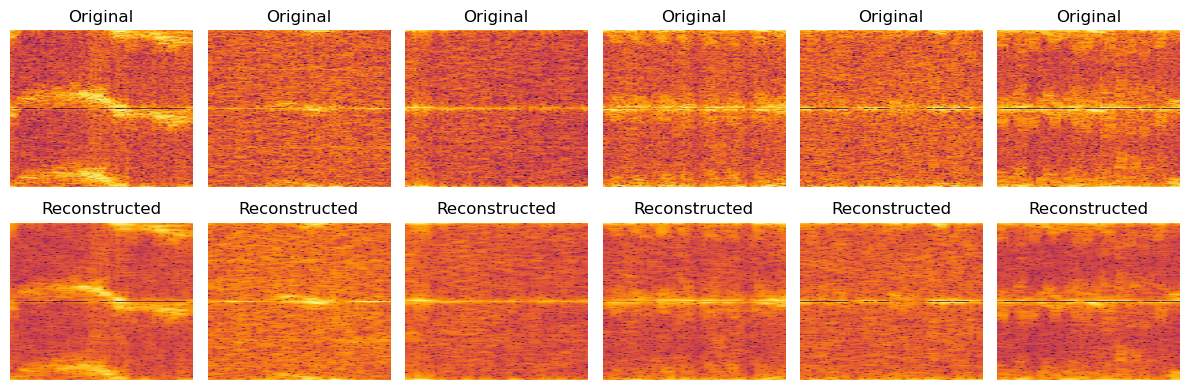

In [15]:
# Define the model again (same config as used during training)
model = VQVAE(in_channels=1, embedding_dim=128, num_embeddings=512, beta=0.25)
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch from the validation loader
device = next(model.parameters()).device
val_iter = iter(val_loader)
batch = next(val_iter).to(device)

# Run the model
with torch.no_grad():
    output = model(batch)
    recon = output["recon_x"]

# Plot original and reconstructed images
n = min(6, batch.size(0))  # number of samples to show
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(batch[i][0].cpu().numpy(), cmap='inferno', aspect='auto')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i][0].cpu().numpy(), cmap='inferno', aspect='auto')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.savefig("output_images/ReconstructionExamples.png")
plt.show()